<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [35]:
!pip install --upgrade tensorflow==2.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 668.3 MB 17 kB/s 
     |████████████████████████████████| 5.8 MB 14.1 MB/s 
     |████████████████████████████████| 1.4 MB 48.2 MB/s 
     |████████████████████████████████| 462 kB 61.9 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.1
    Uninstalling tensorflow-2.9.1:
      Successfully uninstalled tensorflow-2.9.1


In [1]:
import tensorflow
tensorflow.__version__

'2.8.0'

In [2]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [4]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [5]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1k2Dz4oY5uxI3JEaT6m-L2T2HvLkECYIP'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [6]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [7]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [8]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase

df_reviews['Rating'].value_counts()

4    12540
3     4908
2     2823
1     1549
0      821
Name: Rating, dtype: int64

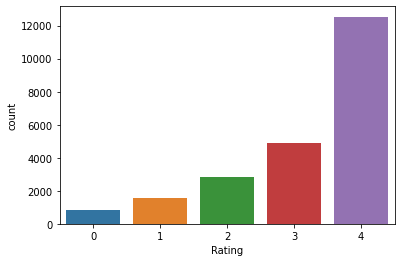

In [9]:
sns.countplot(x='Rating', data=df_reviews)
plt.show()

No esta balanceado, hay mayor cantidad de reviews con alto rating

In [10]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = df_reviews['Review Text'].values
text_sequences.shape

(22641,)

In [11]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
len(text_sequences)

22641

In [12]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(text_sequences)

In [13]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(corpus)

7011643

In [14]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [15]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [16]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens)

1372203

In [40]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 10000
vocab_size = num_words

tok = Tokenizer(num_words=vocab_size) 
tok.fit_on_texts(tokens)

In [41]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

14847

In [42]:
# Alumno: Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)

In [43]:
sequences[0]

[253, 532, 917, 3, 662, 3, 68]

In [44]:
# Alumno: Determinar cual es la oración más larga
max(len(s) for s in sequences)

116

In [45]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from keras_preprocessing.sequence import pad_sequences
maxlen = 115

# Al realizar padding obtener la variable "X" (input)
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [46]:
# Alumno: Observar las dimensiones de la variable input
X.shape

(22641, 115)

In [47]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)
from keras.utils.np_utils import to_categorical

y = to_categorical(df_reviews['Rating'].values, num_classes=5)
print(y.shape)



(22641, 5)


In [48]:
df_reviews['Rating'].values[:10]

array([3, 4, 2, 4, 4, 1, 4, 3, 4, 4])

In [49]:
y[:10]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [50]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
# Alumno: determinar la dimensiones de entrada y salida

in_shape = X_train.shape[1] # max input sentence len
out_shape = 5 # Multi class
print("in_shape", in_shape, ", out_shape", out_shape)


in_shape 115 , out_shape 5


### 2 - Entrenar el modelo con Embeddings + LSTM

In [61]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM, Bidirectional
from keras.layers import Embedding
from keras.layers import Dropout


model = Sequential()
model.add(Embedding(input_dim=min(num_words, len(word_index)), output_dim=100, input_length=in_shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(units=32))
model.add(Dropout(0.2))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=out_shape, activation='softmax'))

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 115, 100)          1000000   
                                                                 
 lstm_14 (LSTM)              (None, 115, 64)           42240     
                                                                 
 dropout_18 (Dropout)        (None, 115, 64)           0         
                                                                 
 lstm_15 (LSTM)              (None, 115, 64)           33024     
                                                                 
 dropout_19 (Dropout)        (None, 115, 64)           0         
                                                                 
 lstm_16 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_20 (Dropout)        (None, 32)               

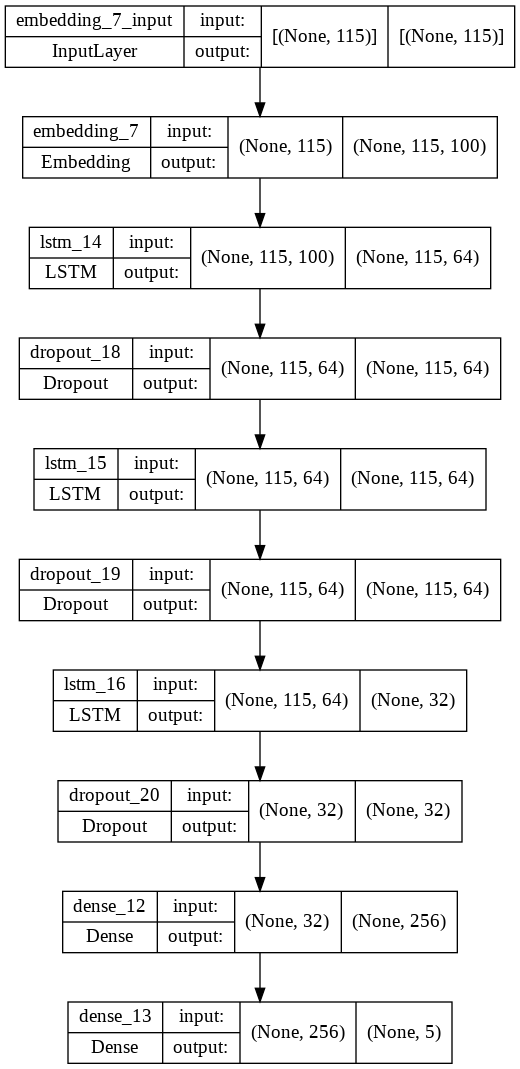

In [62]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [63]:
hist = model.fit(X_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
453/453 [==============================] - 14s 21ms/step - loss: 1.0308 - accuracy: 0.5904 - val_loss: 0.9558 - val_accuracy: 0.6001
Epoch 2/20
453/453 [==============================] - 8s 19ms/step - loss: 0.8564 - accuracy: 0.6337 - val_loss: 0.9369 - val_accuracy: 0.6172
Epoch 3/20
453/453 [==============================] - 8s 19ms/step - loss: 0.7612 - accuracy: 0.6729 - val_loss: 0.9289 - val_accuracy: 0.6147
Epoch 4/20
453/453 [==============================] - 8s 19ms/step - loss: 0.6829 - accuracy: 0.7031 - val_loss: 0.9765 - val_accuracy: 0.6177
Epoch 5/20
453/453 [==============================] - 9s 20ms/step - loss: 0.6098 - accuracy: 0.7417 - val_loss: 1.0955 - val_accuracy: 0.6075
Epoch 6/20
453/453 [==============================] - 9s 20ms/step - loss: 0.5377 - accuracy: 0.7813 - val_loss: 1.1351 - val_accuracy: 0.5832
Epoch 7/20
453/453 [==============================] - 8s 19ms/step - loss: 0.4837 - accuracy: 0.8024 - val_loss: 1.1518 - val_accuracy: 0.590

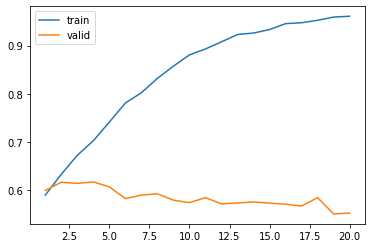

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()


In [65]:
model.evaluate(X_test, y_test)

142/142 [==============================] - 1s 8ms/step - loss: 2.2519 - accuracy: 0.5765


[2.251909017562866, 0.5765069723129272]

OBS:
* Observamos que no se obtienen buenos resultados, tiende a realizar sobre entrenamiento.
* Adjustando la red no pudimos mejorar este resultado.

## Entrenar el modelo con Embeddings Fasttext + LSTM

In [66]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
import os
import gdown
if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KU5qmAYh3LATMvVgocFDfW-PK3prm1WU&export=download'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings fasttext.pkl ya están descargados")

Downloading...
From: https://drive.google.com/uc?id=1KU5qmAYh3LATMvVgocFDfW-PK3prm1WU&export=download
To: /content/fasttext.pkl
100%|██████████| 2.88G/2.88G [00:20<00:00, 141MB/s]


In [67]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [68]:
model_fasttext = FasttextEmbeddings()

In [69]:
# Crear la Embedding matrix

print('preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 2


In [70]:
Embedding(input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=in_shape, # máxima sentencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

In [71]:
model2 = Sequential()
model2.add(Embedding(input_dim=nb_words, output_dim=embed_dim, input_length=in_shape,
                     weights=[embedding_matrix], trainable=False))

model2.add(Bidirectional(LSTM(units=64)))
model2.add(Dropout(0.2))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(units=out_shape, activation='softmax'))

model2.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 115, 300)          3000000   
                                                                 
 bidirectional_7 (Bidirectio  (None, 128)              186880    
 nal)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 128)               16512     
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 5)                 645       
                                                      

In [72]:
hist2 = model2.fit(X_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
453/453 [==============================] - 9s 15ms/step - loss: 1.2275 - accuracy: 0.5517 - val_loss: 1.2340 - val_accuracy: 0.5468
Epoch 2/20
453/453 [==============================] - 6s 14ms/step - loss: 1.1872 - accuracy: 0.5530 - val_loss: 1.1901 - val_accuracy: 0.5443
Epoch 3/20
453/453 [==============================] - 6s 13ms/step - loss: 1.1568 - accuracy: 0.5577 - val_loss: 1.1865 - val_accuracy: 0.5495
Epoch 4/20
453/453 [==============================] - 6s 13ms/step - loss: 1.1371 - accuracy: 0.5617 - val_loss: 1.1597 - val_accuracy: 0.5518
Epoch 5/20
453/453 [==============================] - 6s 13ms/step - loss: 1.1203 - accuracy: 0.5603 - val_loss: 1.1508 - val_accuracy: 0.5534
Epoch 6/20
453/453 [==============================] - 6s 13ms/step - loss: 1.1048 - accuracy: 0.5646 - val_loss: 1.1408 - val_accuracy: 0.5556
Epoch 7/20
453/453 [==============================] - 6s 13ms/step - loss: 1.0932 - accuracy: 0.5676 - val_loss: 1.1470 - val_accuracy: 0.5540

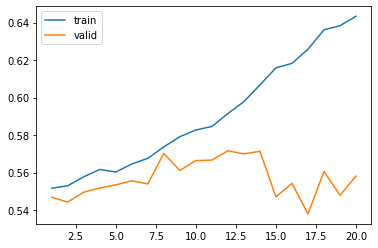

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_accuracy'], label='valid')
plt.show()

In [74]:
model2.evaluate(X_test, y_test)

142/142 [==============================] - 1s 6ms/step - loss: 1.1227 - accuracy: 0.5787


[1.1227061748504639, 0.5787149667739868]

OBS:
* De igual forma no encontramos buenos resultados.
* Se probo varias arquitecturas pero no se encontro algun buen resultado.